# Mini Lab 1: Logistic Regression and Support Vector Machines
### By: Blake Armstrong, Eric Graham, Jack Korbitz
### Data source:
#### https://archive.ics.uci.edu/dataset/45/heart+disease
#### Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1989). Heart Disease [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

### Part 1: Data Orientation
1. Load the raw file, replace “?” with NaN, assign column names, and convert data types appropriately.
Store the clean dataframe in memory for the remainder of the lab.
2. Inspect shape, dtypes, summary statistics, missingness counts, and class balance. Capture at least
three noteworthy observations about the predictors (e.g., feature ranges, skew, class imbalance).
3. Create a feature-level visualization comparing the positive vs negative classes (e.g., histogram or box-
plot of thalach or oldpeak stratified by target). Annotate the plot with a short takeaway.




In [2]:
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv('processed.cleveland.csv', names=column_names, na_values='?')
df = df.dropna()
df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
df['thal'] = pd.to_numeric(df['thal'], errors='coerce')

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [3]:
np.random.seed(123) # set random seed for stochastic steps


In [4]:
df.shape

(297, 14)

In [5]:
df.dtypes

,0
age,int64
sex,int64
cp,int64
trestbps,int64
chol,int64
fbs,int64
restecg,int64
thalach,int64
exang,int64
oldpeak,float64


In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


#### Range of Predictors

We note that our sample ages range from 29 to 77, while the true numeric variables (like chol and thalach) are on very different scales. As noted below, scalers will be used in preprocessing to handle this.

In [7]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


#### Missing Values Check

We note very few missing values in the ca and thal columns, and will drop these instead of imputing them because it has minimal impact on the dataset.

In [8]:
df['target'].value_counts()

,count
target,
0,160
1,54
2,35
3,35
4,13


#### Balance of Target Class

In our target class we notice some imbalance: while the split of zero vs. nonzero values is close (164 to 139), the positive classes for heart disease (1, 2, 3, 4) are diferently balanced, with 1 having the most observations and 4 having the least.

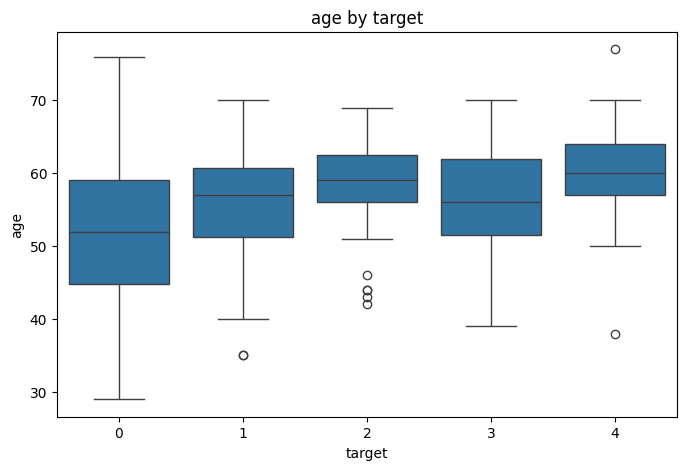

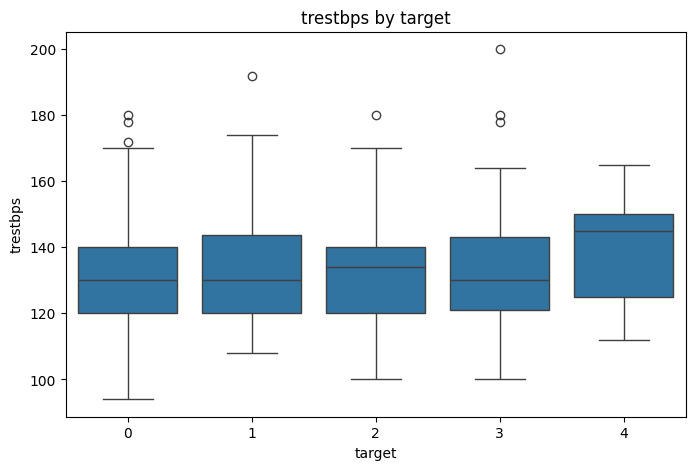

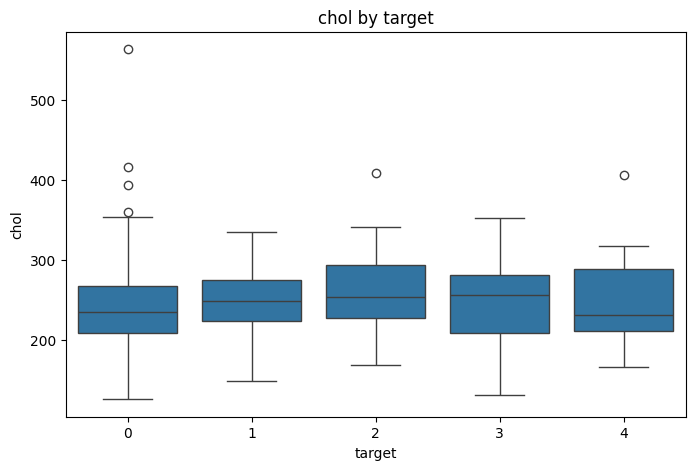

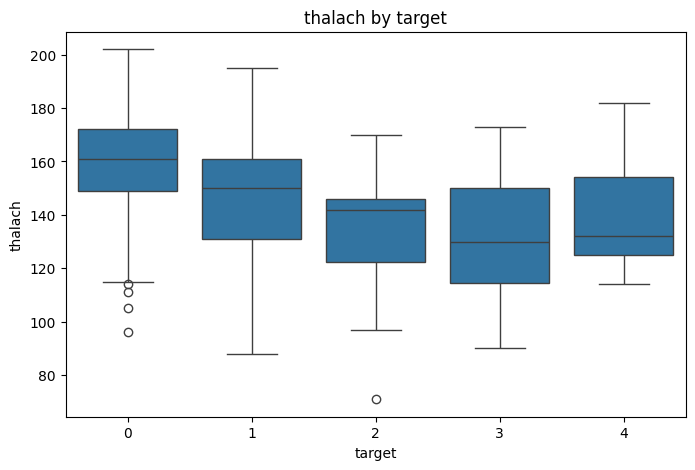

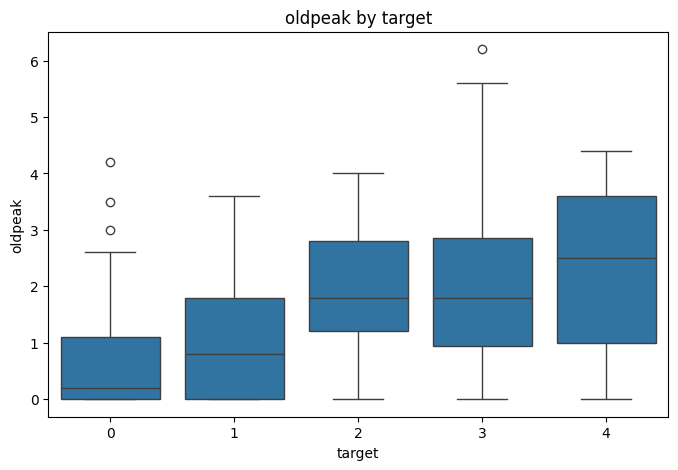

In [9]:
numeric_predictors = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for predictor in numeric_predictors:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='target', y=predictor)
    plt.title(f'{predictor} by target')
    plt.show()

#### Bivariate Analysis of Target Class

1. Higher trestbps is positively correlated heart disease level
2. Thalach negatively correlated to heart disease level
3. Oldpeak is positively correlated heart disease level




### Part 2: Train/Test Split and Preprocessing
1. Perform an 80/20 stratified train/test split using train_test_split with random_state=42.
2. Identify which columns should be treated as numeric vs categorical (e.g., sex, cp, fbs, restecg,
exang, slope, ca, thal). Build a ColumnTransformer that applies StandardScaler to numeric
features and OneHotEncoder(handle_unknown='ignore') to categorical features.
3. Wrap preprocessing and estimators inside a Pipeline. Briefly justify why scaling and consistent
encoding are required before fitting logistic regression or SVM models.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# 1
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# 2
numeric_features = ['age',
                    'trestbps',
                    'chol',
                    'thalach',
                    'oldpeak',
                    'ca']
categorical_features = ['sex',
                        'cp',
                        'fbs',
                        'restecg',
                        'exang',
                        'slope',
                        'thal']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 3
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', penalty='l2', class_weight=None))])

Shape of X_train: (237, 13)
Shape of X_test: (60, 13)
Shape of y_train: (237,)
Shape of y_test: (60,)


Scaling is important for algorithms like Logistic Regression and SVM because they are sensitive to the magnitude and variance of features. Features with larger values can dominate calculations, leading to biased models. Scaling ensures all features contribute equally so we don’t have dominant features.

Consistent encoding is essential for categorical features. It allows them to be converted into a numerical format models can use. `OneHotEncoder` creates binary columns for each category, preventing the model from assuming ordinal relationships between categories. `handle_unknown='ignore'` prevents errors during prediction if a new category is encountered that was not present in the training data.


### Part 3: Logistic Regression Baseline
1. Fit logistic regression with solver='liblinear', penalty='l2', and class_weight=None. Ensure
the model is nested inside the preprocessing pipeline.
2. Evaluate on the held-out test set: accuracy, precision, recall, F1, and confusion matrix. Visualize the
confusion matrix with seaborn.heatmap and annotate counts.
3. Plot the ROC curve and report the area under the curve (AUC). Discuss how class balance influences
the ROC interpretation in a short markdown cell.
4. Retrieve the standardized coefficient vector by accessing the trained logistic regression step. Identify
the top three positive and negative feature contributions (considering one-hot expanded names) and
interpret what they imply about elevated heart disease risk.

Accuracy: 0.583
Precision: 0.493
Recall: 0.583
F1 Score: 0.524


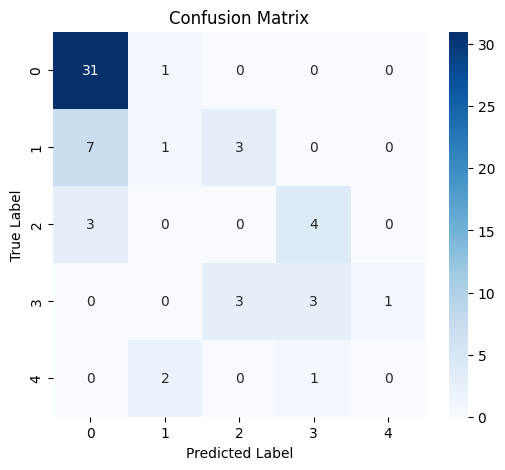

In [11]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print the metrics
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")

# Calc confusion matrix and plot
cm = confusion_matrix(y_test, y_pred)
labels = pipeline.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



The ROC curve plots the true positive rates vs the false positive rates.  Thus, it doesn't get thrown off by the class imbalance and focuses just on how well the model can rank positive positives on prediction scores over the negative.  The ROC is most robust to highly imbalanced classes.

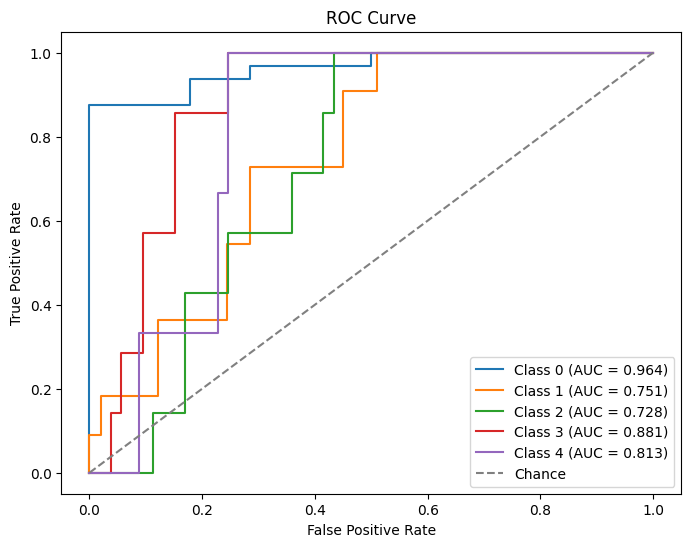

Overall ROC AUC: 0.828


In [12]:
# ROC and AUC for multiclass using one-vs-rest
y_test_binarized = label_binarize(y_test, classes=pipeline.classes_)
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {pipeline.classes_[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate overall AUC using 'ovr'
overall_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"Overall ROC AUC: {overall_auc:.3f}")

In [13]:
# Get the log rog steps and feature names
logreg = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# get coeffs and make a dataframe
coefs = logreg.coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs})

# sort
coef_df = coef_df.sort_values(by='coefficient', ascending=False)

top_pos = coef_df.head(3)
top_neg = coef_df.tail(3)
print("Top 3 positive:")
print(top_pos)

print("\nTop 3 negative:")
print(top_neg)

Top 3 positive:
       feature  coefficient
8    cat__cp_1     0.834360
6   cat__sex_0     0.762734
10   cat__cp_3     0.551092

Top 3 negative:
         feature  coefficient
4   num__oldpeak    -0.656981
11     cat__cp_4    -0.918501
5        num__ca    -1.035283


Positive features increase the log odds of obtaining heart disease while negative features reduce it.

### Part 4: Linear SVM
1. Swap the estimator in the pipeline for LinearSVC(random_state=42) or SVC(kernel='linear',
probability=True) and refit on the training data.
2. Compare test performance (accuracy, precision, recall, F1, AUC) against the logistic regression baseline
in a concise table.
3. Analyze the effect of the C parameter by training at least two additional values (e.g., 0.1, 1, 10).
Summarize how softer vs stiffer margins influence metrics and misclassification patterns.
4. If using SVC, record the number of support vectors per class and comment on how many samples are
defining the margin boundaries.

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

y_pred_lr = y_pred
y_proba_lr = pipeline.predict_proba(X_test)

svc_01 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(kernel='linear', probability=True, random_state=42, C=0.1))])
svc_01.fit(X_train, y_train)
y_pred_01 = svc_01.predict(X_test)
y_proba_01 = svc_01.predict_proba(X_test)

svc_1 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(kernel='linear', probability=True, random_state=42, C=1))])
svc_1.fit(X_train, y_train)
y_pred_1 = svc_1.predict(X_test)
y_proba_1 = svc_1.predict_proba(X_test)

svc_10 = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(kernel='linear', probability=True, random_state=42, C=10))])
svc_10.fit(X_train, y_train)
y_pred_10 = svc_10.predict(X_test)
y_proba_10 = svc_10.predict_proba(X_test)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVC C=0.1', 'SVC C=1', 'SVC C=10'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_01), accuracy_score(y_test, y_pred_1), accuracy_score(y_test, y_pred_10)],
    'Precision': [precision_score(y_test, y_pred_lr, average='weighted'), precision_score(y_test, y_pred_01, average='weighted'), precision_score(y_test, y_pred_1, average='weighted'), precision_score(y_test, y_pred_10, average='weighted')],
    'Recall': [recall_score(y_test, y_pred_lr, average='weighted'), recall_score(y_test, y_pred_01, average='weighted'), recall_score(y_test, y_pred_1, average='weighted'), recall_score(y_test, y_pred_10, average='weighted')],
    'F1': [f1_score(y_test, y_pred_lr, average='weighted'), f1_score(y_test, y_pred_01, average='weighted'), f1_score(y_test, y_pred_1, average='weighted'), f1_score(y_test, y_pred_10, average='weighted')]
})

print(results.round(4))

print('\nSupport Vectors:')
print('C=0.1:', svc_01.named_steps['classifier'].n_support_)
print('C=1:', svc_1.named_steps['classifier'].n_support_)
print('C=10:', svc_10.named_steps['classifier'].n_support_)

auc_lr = roc_auc_score(y_test, y_proba_lr, multi_class='ovr', average='weighted')
auc_01 = roc_auc_score(y_test, y_proba_01, multi_class='ovr', average='weighted')
auc_1 = roc_auc_score(y_test, y_proba_1, multi_class='ovr', average='weighted')
auc_10 = roc_auc_score(y_test, y_proba_10, multi_class='ovr', average='weighted')

print('\nAUC Scores:')
print(f'Logistic Regression: {auc_lr:.4f}')
print(f'SVC C=0.1: {auc_01:.4f}')
print(f'SVC C=1: {auc_1:.4f}')
print(f'SVC C=10: {auc_10:.4f}')

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 Model  Accuracy  Precision  Recall      F1
0  Logistic Regression    0.5833     0.4928  0.5833  0.5241
1            SVC C=0.1    0.5500     0.4228  0.5500  0.4780
2              SVC C=1    0.5667     0.4890  0.5667  0.5220
3             SVC C=10    0.6000     0.5266  0.6000  0.5509

Support Vectors:
C=0.1: [52 43 28 28 10]
C=1: [48 43 28 27 10]
C=10: [45 43 27 25 10]

AUC Scores:
Logistic Regression: 0.8804
SVC C=0.1: 0.8731
SVC C=1: 0.8590
SVC C=10: 0.8435


As C increases, we see that model performance increases, but that may be a bias-variance tradeoff which risks overfitting. Likewise, we see less support vectors as C increases, which indicates that a model with stiffer margins will require less samples to define the decision boundary.

### Part 5: Nonlinear SVM with RBF Kernel
1. Use SVC(kernel='rbf', probability=True) inside the pipeline and run a lightweight hyperparam-
eter search over C and gamma (e.g., {0.1,1,10}) using GridSearchCV with 3-fold cross-validation.
2. Report the best parameters, cross-validated score, and resulting test metrics. Plot the ROC curve
alongside the logistic baseline for visual comparison.
3. Reflect on scenarios where the nonlinear decision boundary is advantageous or prone to overfitting, referencing differences in metrics and support vector counts.

Best parameters: {'classifier__C': 1, 'classifier__gamma': 0.1}
Best cross-validation score: 0.5991561181434598

Test Metrics for Best RBF SVM:
Accuracy: 0.5333
Precision: 0.4089
Recall: 0.5333
F1 Score: 0.4628
AUC: 0.8191


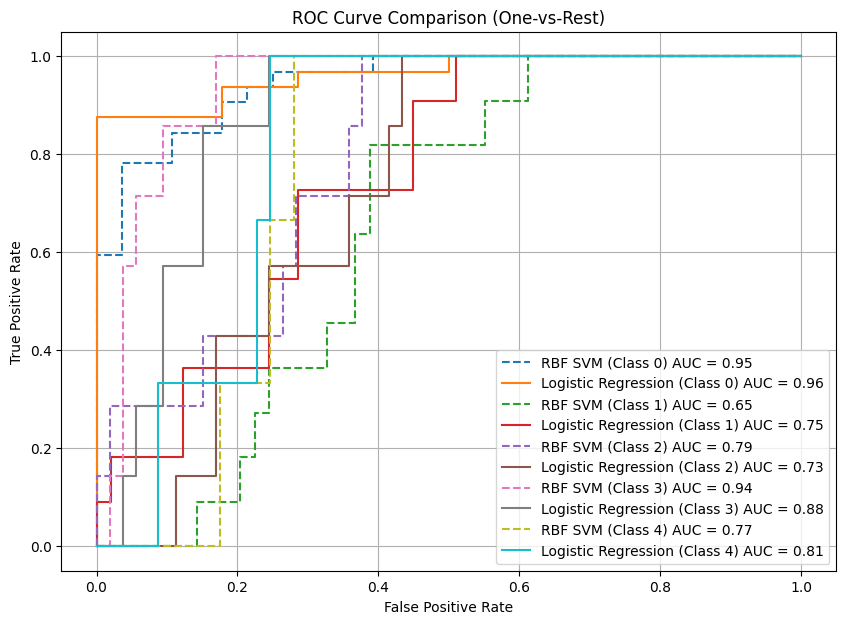


Number of support vectors per class (Best RBF SVM): [75 43 28 28 10]


In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression # Import LogisticRegression
from sklearn.preprocessing import label_binarize

rbf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', SVC(kernel='rbf', probability=True, random_state=42))])

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [0.1, 1, 10]
}

grid_search = GridSearchCV(rbf_pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_rbf_model = grid_search.best_estimator_
y_pred_rbf = best_rbf_model.predict(X_test)
y_proba_rbf = best_rbf_model.predict_proba(X_test)

rbf_accuracy = accuracy_score(y_test, y_pred_rbf)
rbf_precision = precision_score(y_test, y_pred_rbf, average='weighted', zero_division=0)
rbf_recall = recall_score(y_test, y_pred_rbf, average='weighted')
rbf_f1 = f1_score(y_test, y_pred_rbf, average='weighted')
rbf_auc = roc_auc_score(y_test, y_proba_rbf, multi_class='ovr')

print("\nTest Metrics for Best RBF SVM:")
print(f"Accuracy: {rbf_accuracy:.4f}")
print(f"Precision: {rbf_precision:.4f}")
print(f"Recall: {rbf_recall:.4f}")
print(f"F1 Score: {rbf_f1:.4f}")
print(f"AUC: {rbf_auc:.4f}")

baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])
baseline_pipeline.fit(X_train, y_train)
y_proba_lr = baseline_pipeline.predict_proba(X_test)

y_test_binarized = label_binarize(y_test, classes=best_rbf_model.classes_)

plt.figure(figsize=(10, 7))
for i in range(len(best_rbf_model.classes_)):
    fpr_rbf, tpr_rbf, _ = roc_curve(y_test_binarized[:, i], y_proba_rbf[:, i])
    roc_auc_rbf = auc(fpr_rbf, tpr_rbf)
    plt.plot(fpr_rbf, tpr_rbf, linestyle='--', label=f'RBF SVM (Class {best_rbf_model.classes_[i]}) AUC = {roc_auc_rbf:.2f}')
    fpr_lr, tpr_lr, _ = roc_curve(y_test_binarized[:, i], y_proba_lr[:, i])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, linestyle='-', label=f'Logistic Regression (Class {baseline_pipeline.classes_[i]}) AUC = {roc_auc_lr:.2f}')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.show()

svc_model = best_rbf_model.named_steps['classifier']
print("\nNumber of support vectors per class (Best RBF SVM):", svc_model.n_support_)

The RBF kernel enables nonlinear decision boundaries, useful when classes are not linearly separable. In this dataset, the best RBF SVM (C=1, gamma=0.1) achieved lower accuracy (0.5333) and F1 (0.4628) than linear models, but a comparable AUC (0.8191 vs. 0.8275 for Logistic Regression), showing it still ranks cases well.

RBF SVMs are prone to overfitting with high C or gamma, which create overly complex boundaries. The relatively large number of support vectors here also suggests higher model complexity. Nonlinear models are valuable when data patterns are complex, but linear models often generalize better on simpler or noisy datasets.

### Part 6: Synthesis and Communication
*   **Summarize key similarities and differences between logistic regression, linear SVM, and RBF SVM on this dataset.**
    *   **Similarities:** Logistic Regression and Linear SVM are linear models with comparable performance on this dataset.
    *   **Differences:** LR provides interpretable coefficients and direct probabilities. Linear SVM maximizes margin. RBF SVM is nonlinear, less interpretable, and potentially more prone to overfitting but can capture complex patterns.
*   **State two criteria you would use to choose among these models in a production setting.**
    1.  **Interpretability:** Choose LR if feature importance is needed.
    2.  **Computational Efficiency:** Linear models (LR, Linear SVM) are faster for large datasets.
*   **List one question that remains unanswered and how you would investigate it with more time (e.g.,richer hyperparameter search, feature creation, probability calibration)**
    *   **Question:** Can a more thorough hyperparameter search improve RBF SVM performance?
    *   **Investigation:** Conduct a broader grid/randomized search for RBF `C` and `gamma` with cross-validation.

#### Model Metrics

| Model | Accuracy | Precision | Recall | F1 Score | AUC |
|-------|----------|-----------|--------|----------|-----|
| Linear Regression (Baseline) | 0.583 | 0.493 | 0.583 | 0.524 | 0.828 |
| Linear SVM (C=10) | 0.600 | 0.527 | 0.600 | 0.551 | 0.844 |
| RBF SVM (C=1, γ=0.1) | 0.533 | 0.409 | 0.533 | 0.463 | 0.819 |